In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


In [2]:
# Load dataset
df = pd.read_csv("/content/breast-cancer-wisconsin-data_data.csv")

# Drop unnecessary columns
df.drop(columns=['id', 'Unnamed: 32'], errors='ignore', inplace=True)

# Encode target variable
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Split features and labels
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:36:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


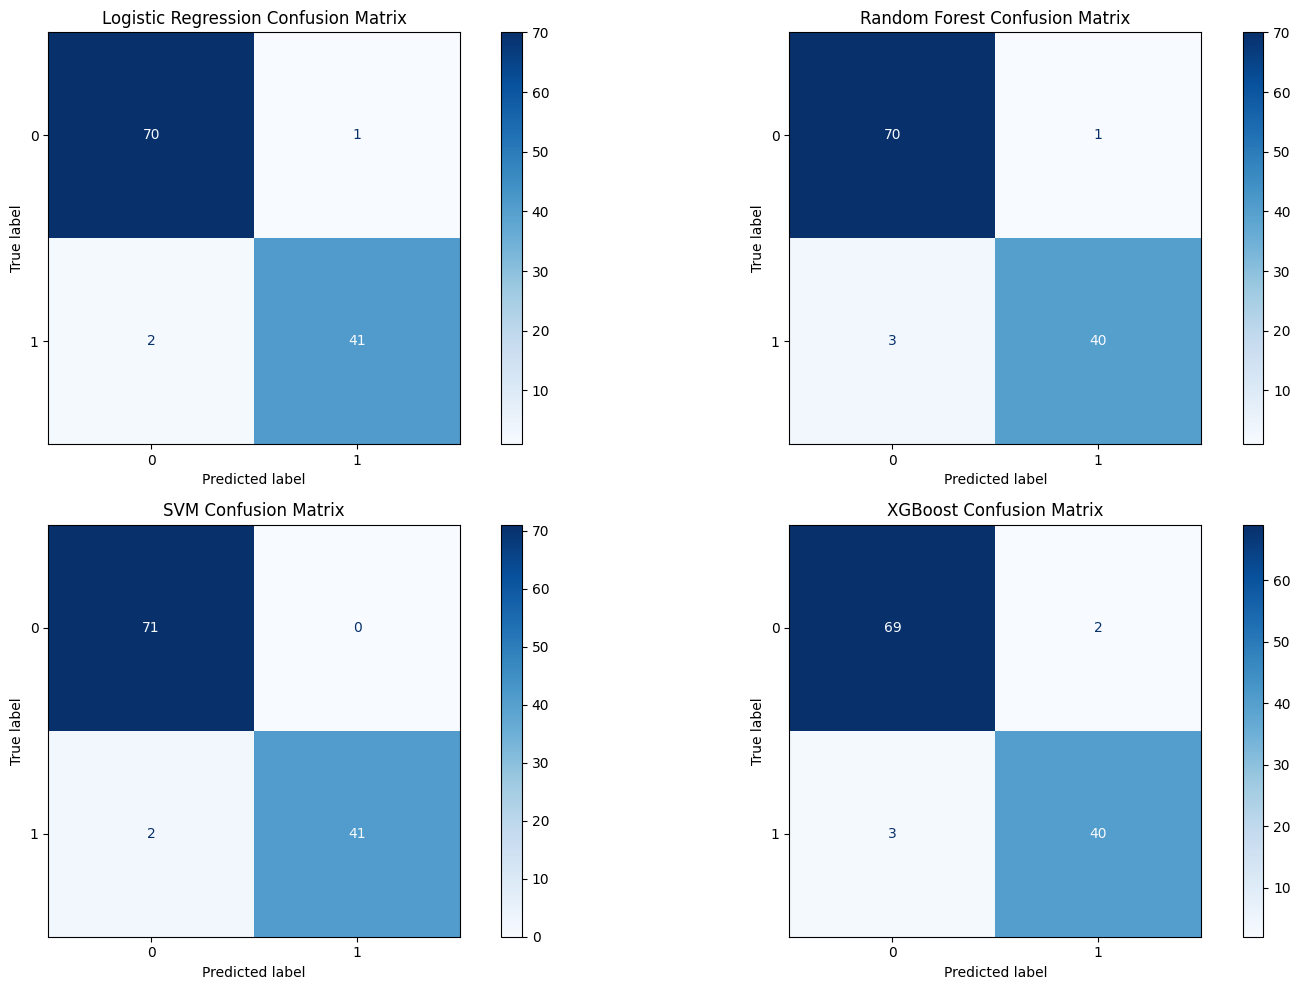

In [3]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

plt.figure(figsize=(16, 10))

for i, (name, model) in enumerate(models.items(), 1):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    plt.subplot(2, 2, i)
    disp.plot(cmap='Blues', ax=plt.gca(), values_format='d')
    plt.title(f"{name} Confusion Matrix")

plt.tight_layout()
plt.show()


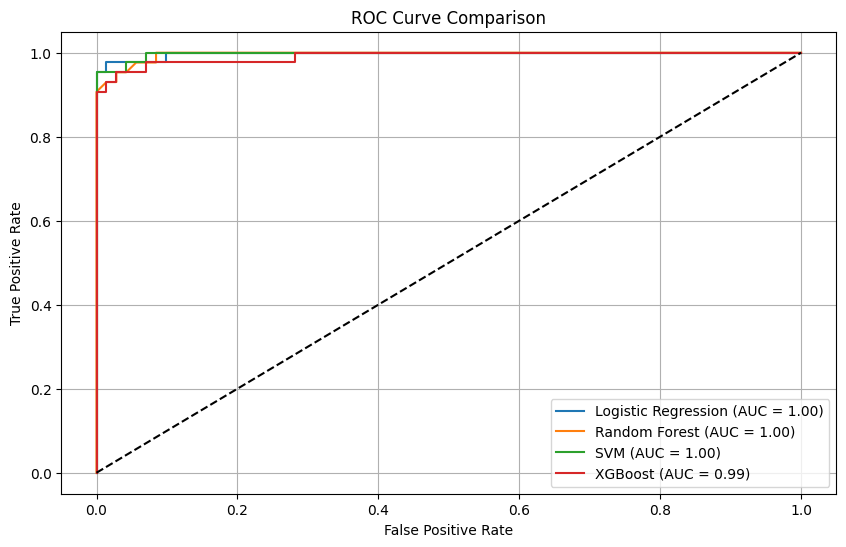

In [4]:
plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [5]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 6, 8]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score (CV):", grid_search.best_score_)

# Evaluate tuned model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print("\nTuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred))


Best Parameters: {'max_depth': 8, 'n_estimators': 100}
Best F1 Score (CV): 0.9456045136455584

Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

